In [1]:
import xarray as xr
from extremeweatherbench import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def convert_climatology_to_hourly(freeze_threshold_climatology, era5_time_subset):
    """
    Convert the freeze threshold climatology to hourly values.
    """
    # Extract hour and dayofyear from the time coordinate
    hours = era5_time_subset.time.dt.hour
    dayofyear = era5_time_subset.time.dt.dayofyear

    # Create a mask for each timestamp where temperature exceeds the threshold
    threshold_values = []
    
    for i, timestamp in enumerate(era5_time_subset.time.values):
        hour = hours[i].item()
        doy = dayofyear[i].item()
        # Get the threshold value for this hour and day of year
        threshold = freeze_threshold_climatology.sel(hour=hour, dayofyear=doy)
        threshold_values.append(threshold)
    
    # Stack the threshold values into a DataArray with the same dimensions as era5_time_subset
    threshold_da = xr.concat(threshold_values, dim='time')
    threshold_da['time'] = era5_time_subset.time
    return threshold_da

def identify_freeze_periods(era5_time_subset, freeze_threshold_climatology):
    """
    Identify freeze periods based on temperature falling below the 15th percentile threshold.
    
    Args:
        era5_time_subset: xarray DataArray containing temperature data for a specific time period
        freeze_threshold_climatology: xarray DataArray containing the 15th percentile threshold values
        
    Returns:
        xarray DataArray with boolean mask indicating freeze periods
    """
    threshold_da = convert_climatology_to_hourly(freeze_threshold_climatology, era5_time_subset)

    # Step 1: Create boolean mask where temperature falls below threshold
    below_threshold = era5_time_subset <= threshold_da
    
    # Step 2 & 3: Identify periods of 2+ days with allowance for short gaps
    # Check data frequency - assuming 6-hourly data (4 timestamps per day)
    time_diff = pd.to_datetime(era5_time_subset.time.values[1]) - pd.to_datetime(era5_time_subset.time.values[0])
    hours_between_samples = time_diff.total_seconds() / 3600
    samples_per_day = 24 / hours_between_samples
    
    min_duration = int(2 * samples_per_day)  # 2 days worth of samples
    max_gap = int(0.5*samples_per_day)  # Allow for up to 1 days gap
    
    # Convert to numpy for easier processing
    mask_np = below_threshold.values
    result_mask = np.zeros_like(mask_np, dtype=bool)
    
    # Check if we have spatial dimensions
    has_lat = 'latitude' in below_threshold.dims
    has_lon = 'longitude' in below_threshold.dims
    
    # If we don't have spatial dimensions, process as a 1D time series
    if not (has_lat or has_lon):
        time_series = mask_np
        
        # Find potential freeze periods
        i = 0
        while i < len(time_series):
            if time_series[i]:
                # Found start of a potential freeze
                start_idx = i
                current_run = 1
                i += 1
                
                # Track the run, allowing for gaps
                while i < len(time_series):
                    if time_series[i]:
                        current_run += 1
                        i += 1
                    else:
                        # Check if this is a gap we can bridge
                        gap_start = i
                        gap_length = 0
                        
                        while i < len(time_series) and not time_series[i] and gap_length < max_gap:
                            gap_length += 1
                            i += 1
                        
                        # If we found True values after a short gap, continue the run
                        if i < len(time_series) and time_series[i]:
                            current_run += gap_length + 1  # Count the gap and the new True
                            i += 1
                        else:
                            # End of run or gap too long
                            break
                
                # Check if the run is long enough to be a freeze
                if current_run >= min_duration:
                    # Mark the entire period as a freeze, including any gaps
                    result_mask[start_idx:i] = True
            else:
                i += 1
    else:
        # Iterate through the spatial dimensions if they exist
        for lat_idx in range(mask_np.shape[1] if has_lat else 1):
            for lon_idx in range(mask_np.shape[2] if has_lon else 1):
                if has_lat and has_lon:
                    time_series = mask_np[:, lat_idx, lon_idx]
                    result_series = result_mask[:, lat_idx, lon_idx]
                elif has_lat:
                    time_series = mask_np[:, lat_idx]
                    result_series = result_mask[:, lat_idx]
                elif has_lon:
                    time_series = mask_np[:, lon_idx]
                    result_series = result_mask[:, lon_idx]
                
                # Find potential freeze periods
                i = 0
                while i < len(time_series):
                    if time_series[i]:
                        # Found start of a potential freeze
                        start_idx = i
                        current_run = 1
                        i += 1
                        
                        # Track the run, allowing for gaps
                        while i < len(time_series):
                            if time_series[i]:
                                current_run += 1
                                i += 1
                            else:
                                # Check if this is a gap we can bridge
                                gap_start = i
                                gap_length = 0
                                
                                while i < len(time_series) and not time_series[i] and gap_length < max_gap:
                                    gap_length += 1
                                    i += 1
                                
                                # If we found True values after a short gap, continue the run
                                if i < len(time_series) and time_series[i]:
                                    current_run += gap_length + 1  # Count the gap and the new True
                                    i += 1
                                else:
                                    # End of run or gap too long
                                    break
                        
                        # Check if the run is long enough to be a freeze
                        if current_run >= min_duration:
                            # Mark the entire period as a freeze, including any gaps
                            result_series[start_idx:i] = True
                    else:
                        i += 1
    
    # Convert back to xarray DataArray
    result = xr.DataArray(
        result_mask,
        dims=below_threshold.dims,
        coords=below_threshold.coords
    )
    
    return result

def extend_freeze_period(freeze_mask, hours=48):
    """
    Extends the freeze period by adding a specified number of hours to the start and end of each freeze period.
    
    Args:
        freeze_mask (xr.DataArray): Boolean mask indicating freeze periods (True for freeze, False otherwise)
        hours (int): Number of hours to extend the freeze period by on each end
        
    Returns:
        tuple: (start_date, end_date) - The start and end dates of the extended freeze period
    """
    # Convert to numpy array for easier manipulation
    mask_values = freeze_mask.values
    time_values = freeze_mask.time.values
    
    # Find transitions from False to True (start of freeze) and True to False (end of freeze)
    transitions = np.diff(mask_values.astype(int))
    starts_idx = np.where(transitions == 1)[0] + 1  # +1 because diff gives index before transition
    ends_idx = np.where(transitions == -1)[0] + 1   # +1 to include the last True value
    
    # Handle edge cases where the series starts or ends with True
    if mask_values[0]:
        starts_idx = np.insert(starts_idx, 0, 0)
    if mask_values[-1]:
        ends_idx = np.append(ends_idx, len(mask_values) - 1)
    
    # If no freeze periods found, return None
    if len(starts_idx) == 0 or len(ends_idx) == 0:
        return None, None
    
    # Convert time index to datetime
    time_index = pd.DatetimeIndex(time_values)
    
    # Calculate the extended start and end times
    # Determine time step in hours
    time_diff = pd.to_datetime(time_index[1]) - pd.to_datetime(time_index[0])
    hours_between_samples = time_diff.total_seconds() / 3600
    samples_to_extend = int(hours / hours_between_samples)
    
    # For the earliest start, subtract hours
    earliest_start_idx = max(0, starts_idx[0] - samples_to_extend)
    # For the latest end, add hours
    latest_end_idx = min(len(time_index) - 1, ends_idx[-1] + samples_to_extend)
    
    start_date = time_index[earliest_start_idx]
    end_date = time_index[latest_end_idx]
    
    return start_date, end_date




In [3]:
freeze_threshold_climatology = xr.open_dataset('era5_freeze_climatology.nc')

era5 = xr.open_zarr('gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',chunks=None,storage_options={'anon':True})

1. Load in each case
2. Get the 85th percentile of the temperature data
3. Run function that takes in the 85th percentile and returns a boolean mask of the freeze cases
4. Run function that creates boolean mask based on when 85th percentile is exceeded for >=2 consecutive days
--> This should also allow for at least one period of 2 days in the middle of the freeze where the temperature is below the 85th percentile
5. Add +-48 hours to the start and end of the freeze case
6. Save the boolean mask

In [4]:
freeze_threshold_climatology = freeze_threshold_climatology['2m_temperature']

2021-02-10 12:00:00 2021-02-22 00:00:00


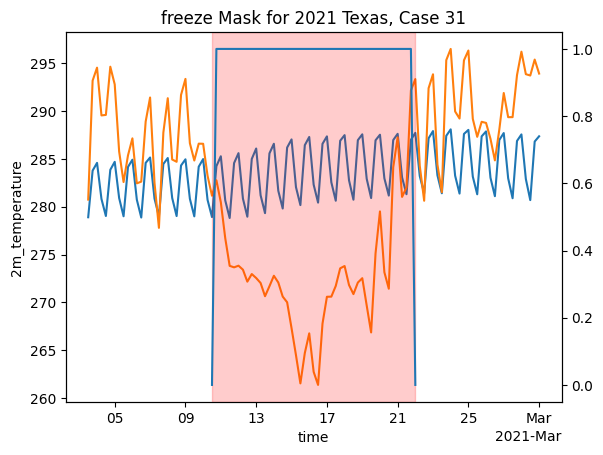

2022-02-12 12:00:00 2022-03-01 06:00:00


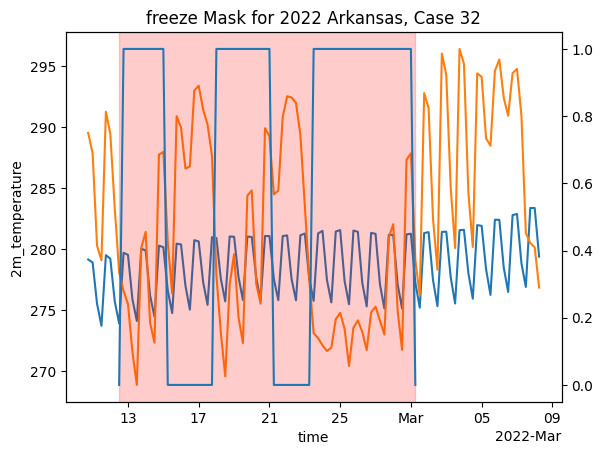

2023-12-02 06:00:00 2023-12-05 18:00:00


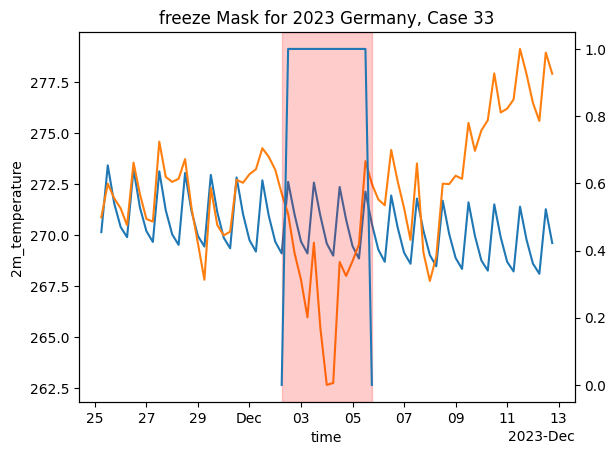

2023-12-15 06:00:00 2023-12-26 18:00:00


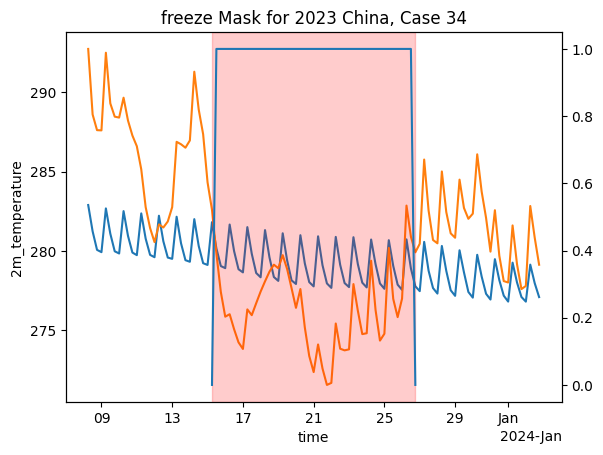

2023-01-11 06:00:00 2023-01-28 00:00:00


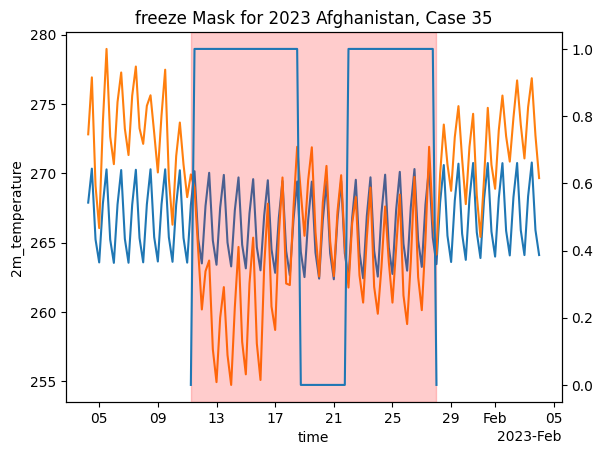

2022-04-06 00:00:00 2022-04-16 00:00:00


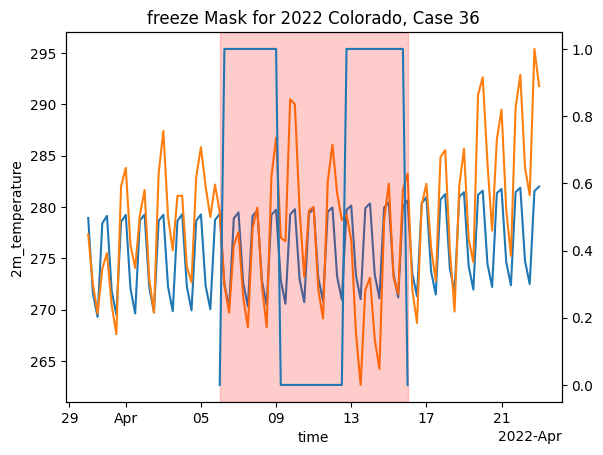

2024-01-11 12:00:00 2024-01-20 00:00:00


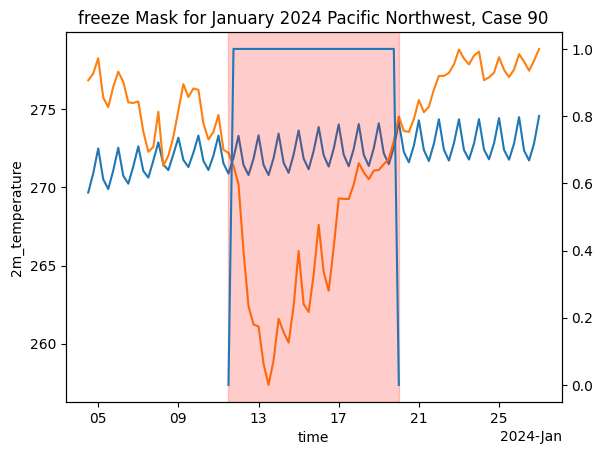

2022-04-11 18:00:00 2022-04-16 12:00:00


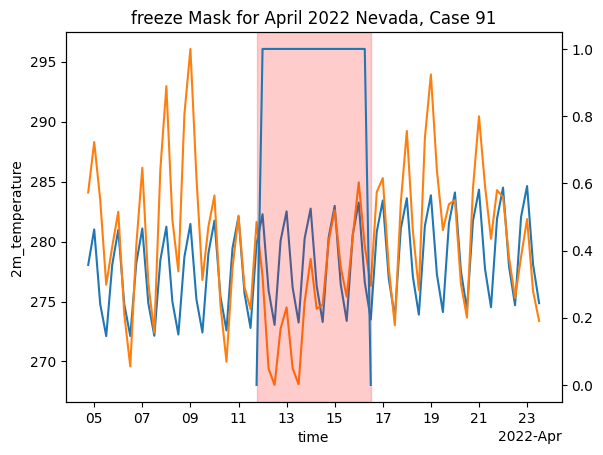

2021-03-04 18:00:00 2021-03-09 06:00:00


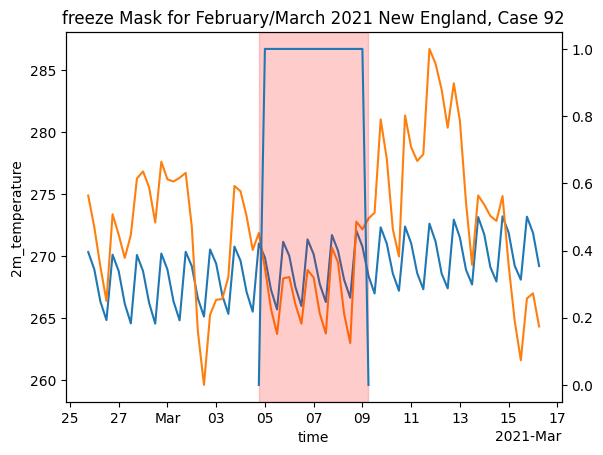

2024-01-01 06:00:00 2024-01-18 00:00:00


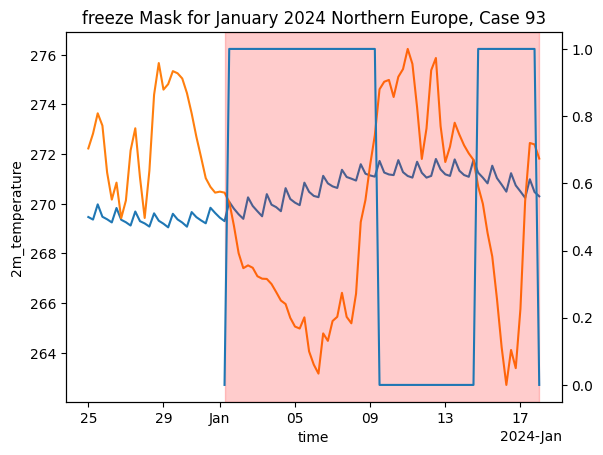

2022-12-10 06:00:00 2022-12-20 00:00:00


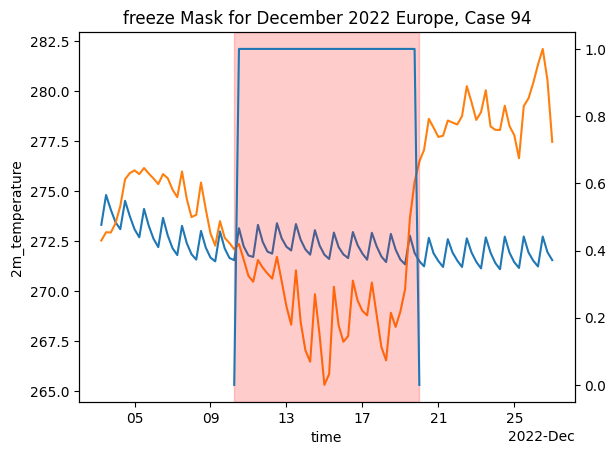

2024-04-16 12:00:00 2024-04-27 12:00:00


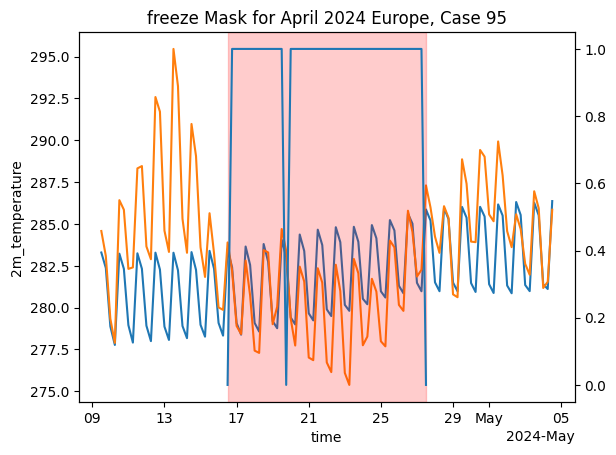

2024-01-20 00:00:00 2024-02-04 18:00:00


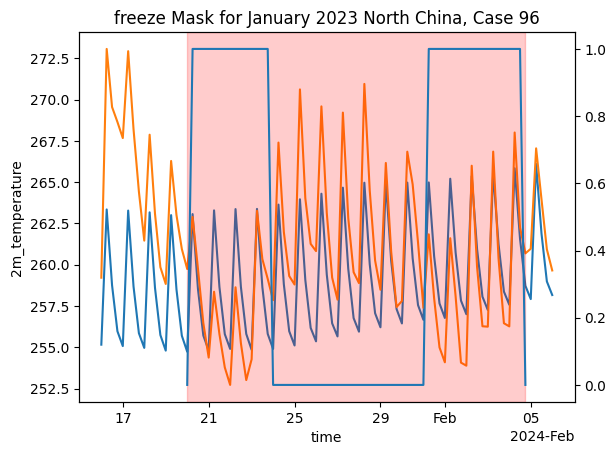

2024-04-02 00:00:00 2024-04-07 12:00:00


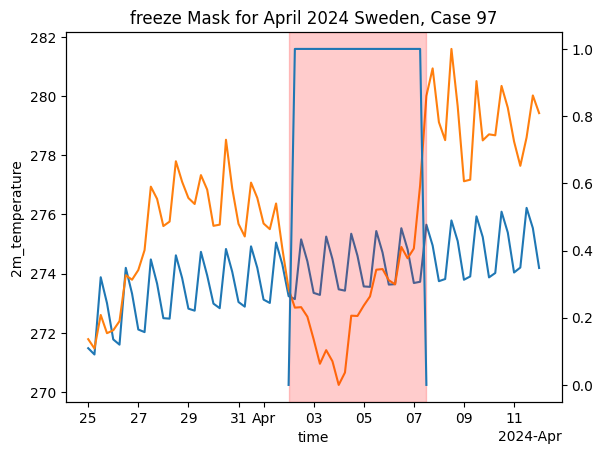

In [8]:
yaml_event_case = utils.load_events_yaml()
for individual_case in yaml_event_case['cases'][27:]:
    if individual_case['event_type'] == 'freeze':
        fig, ax = plt.subplots()    
        individual_case = individual_case
        individual_case["location"]["longitude"] = (
            utils.convert_longitude_to_360(
                individual_case["location"]["longitude"]
            )
        )
        individual_case["location"] = utils.Location(
        **individual_case["location"]
        )
        individual_case["start_date"] = pd.to_datetime(individual_case["start_date"]) - pd.Timedelta(hours=168)
        individual_case["end_date"] = pd.to_datetime(individual_case["end_date"]) + pd.Timedelta(hours=168)

        begin_date_bool = True
        end_date_bool = True

        def find_complete_freeze_period(individual_case):
            era5_time_subset = era5.sel(time=slice(individual_case["start_date"],individual_case["end_date"]))['2m_temperature']
            # Subset to only include hours 0, 6, 12, and 18
            era5_time_subset = era5_time_subset.sel(time=era5_time_subset.time.dt.hour.isin([0, 6, 12, 18]))
            era5_spatiotemporal_subset = utils.clip_dataset_to_bounding_box_degrees(era5_time_subset, individual_case["location"], individual_case["bounding_box_degrees"])
            freeze_threshold_climatology_subset = utils.clip_dataset_to_bounding_box_degrees(freeze_threshold_climatology, individual_case["location"], individual_case["bounding_box_degrees"])
            era5_mean_subset = era5_spatiotemporal_subset.mean(dim=['latitude','longitude'])
            freeze_threshold_climatology_mean_subset = freeze_threshold_climatology_subset.mean(dim=['latitude','longitude'])
            threshold_da = convert_climatology_to_hourly(freeze_threshold_climatology_mean_subset, era5_mean_subset)
            freeze_mask = identify_freeze_periods(era5_mean_subset, freeze_threshold_climatology_mean_subset)
            try:
                if not freeze_mask[1]:
                    while not freeze_mask[1]:
                        freeze_mask = freeze_mask[1:]
                if not freeze_mask[-2]:
                    while not freeze_mask[-2]:
                        freeze_mask = freeze_mask[:-1]
            except IndexError:
                print(f'no freeze found for case {individual_case["id"]}')
            begin_date_bool = freeze_mask.isel(time=0)
            end_date_bool = freeze_mask.isel(time=-1)
            return begin_date_bool, end_date_bool, threshold_da, freeze_mask, era5_mean_subset
        

        while begin_date_bool:
            begin_date_bool, end_date_bool, threshold_da, freeze_mask, era5_mean_subset = find_complete_freeze_period(individual_case)
            individual_case["start_date"] = individual_case["start_date"] - pd.Timedelta(hours=6)
        while end_date_bool:
            begin_date_bool, end_date_bool, threshold_da, freeze_mask, era5_mean_subset = find_complete_freeze_period(individual_case)
            individual_case["end_date"] = individual_case["end_date"] + pd.Timedelta(hours=6)
        threshold_da.plot(ax=ax)
        era5_mean_subset.plot(ax=ax)
        ax2 = ax.twinx()
        try:
            freeze_mask.plot(ax=ax2)
            plt.axvspan(freeze_mask.time[0].values, freeze_mask.time[-1].values, color='red', alpha=0.2)
        except TypeError:
            print(f'no freeze found for case {individual_case["id"]}')
        ax2.set_title(f"freeze Mask for {individual_case['title']}, Case {individual_case['id']}")
        start_date, end_date = extend_freeze_period(freeze_mask)

        print(start_date, end_date)
        plt.show()

